In [1]:
import subprocess
import shlex
import re
import csv

import numpy as np

from io import StringIO
from matplotlib import pyplot as plt
from scipy.stats import spearmanr, combine_pvalues
from IPython.display import display, Markdown

# Spearman correlation between four adjacent non-dispersing individuals

In [2]:
def test_rng_correlation(
    seeds=[42], limit=1000,
):
    total_correlations = np.zeros(shape=(4, 4))
    total_pvalues = []
    
    for seed in seeds:
        # Collect random streams from non-dispersing individuals at (0,0)..(1,1)
        rngs_io = StringIO(subprocess.run(shlex.split(
            f"cargo run --release --quiet -- --seed {seed} --limit {limit}"
        ), check=True, capture_output=True, text=True).stdout)
        
        # Read in the random draws and transpose to 4xlimit
        rngs = []
        with rngs_io:
            reader = csv.reader(rngs_io)

            for row in reader:
                rngs.append(tuple(np.uint64(c) for c in row))
        rngs = np.array(rngs).T
        
        zzCzo = spearmanr(rngs[0], rngs[1])
        zzCoz = spearmanr(rngs[0], rngs[2])
        zzCoo = spearmanr(rngs[0], rngs[3])
        zoCoz = spearmanr(rngs[1], rngs[2])
        zoCoo = spearmanr(rngs[1], rngs[3])
        ozCoo = spearmanr(rngs[2], rngs[3])
        
        total_correlations[0,1] += zzCzo.correlation
        total_correlations[1,0] -= zzCzo.correlation
        
        total_correlations[0,2] += zzCoz.correlation
        total_correlations[2,0] -= zzCoz.correlation
        
        total_correlations[0,3] += zzCoo.correlation
        total_correlations[3,0] -= zzCoo.correlation
        
        total_correlations[1,2] += zoCoz.correlation
        total_correlations[2,1] -= zoCoz.correlation
        
        total_correlations[1,3] += zoCoo.correlation
        total_correlations[3,1] -= zoCoo.correlation
        
        total_correlations[2,3] += ozCoo.correlation
        total_correlations[3,2] -= ozCoo.correlation
        
        total_pvalues.append(zzCzo.pvalue)
        total_pvalues.append(zzCoz.pvalue)
        total_pvalues.append(zzCoo.pvalue)
        total_pvalues.append(zoCoz.pvalue)
        total_pvalues.append(zoCoo.pvalue)
        total_pvalues.append(ozCoo.pvalue)
        
    total_correlations /= limit
    
    corr_statistic, corr_pvalue = combine_pvalues(total_pvalues)
    
    if corr_pvalue <= 0.01 or corr_pvalue >= 0.99:
        display(Markdown(f"## <span style='color:purple'><u>Definitely Correlated</u></span>"))
    elif corr_pvalue <= 0.05 or corr_pvalue >= 0.95:
        display(Markdown(f"## <span style='color:red'><u>Strongly Correlated</u></span>"))
    elif corr_pvalue <= 0.1 or corr_pvalue >= 0.9:
        display(Markdown(f"## <span style='color:orange'>*Weakly Correlated*</span>"))
    else:
        display(Markdown(f"## <span style='color:green'>Uncorrelated</span>"))
        
    display(Markdown("#### Fisher’s combined Spearman correlation coefficients:"))
    display(Markdown(f"* p-value: {corr_pvalue}\n* statistic: {corr_statistic}"))
    
    display(Markdown("#### Correlation matrix:"))
    
    plt.figure(figsize=(8, 8))
    mat = plt.matshow(total_correlations, fignum=1)
    mat.axes.set_title("Individual Spearman correlation coefficients")
    mat.axes.set_xticks([0, 1, 2, 3])
    mat.axes.set_yticks([0, 1, 2, 3])
    mat.axes.set_xticklabels(['(0,0)', '(0,1)', '(1,0)', '(1,1)'])
    mat.axes.set_yticklabels(['(0,0)', '(0,1)', '(1,0)', '(1,1)'])
    plt.colorbar()
    plt.show()

## <span style='color:green'>Uncorrelated</span>

#### Fisher’s combined Spearman correlation coefficients:

* p-value: 0.5239515957151741
* statistic: 118.4087577351819

#### Correlation matrix:

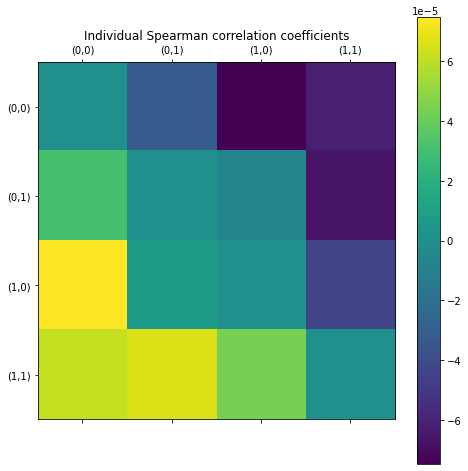

In [3]:
seeds = np.random.randint(0, np.iinfo("uint64").max, dtype="uint64", size=10)

test_rng_correlation(seeds=seeds, limit=1000)